# Text classifier demo

In this notebook, we use a dataset with 120000 news to train a model to classify them into 4 classes:

1. World
2. Sports
3. Business
4. Sci/Tech

First, let's import all the necessary libraries.

In [1]:
# Import libraries
from typing import Dict, List
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import text_to_word_sequence
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

warnings.filterwarnings("ignore")

2024-09-25 11:32:06.872568: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 11:32:06.874411: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 11:32:06.910031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 11:32:06.910846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 11:32:07.620823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Our dataset is divided in two files: <code>train.csv</code> contains the training data and <code>test.txt</code> the testing one. Both have the same format. Each record has three columns which include the category of the news, the headline and the text in that order.

In [2]:
# Read training data
data = pd.read_csv("../data/train.csv", header=None, names=["category", "headline", "text"])
data.head()

,category,headline,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  120000 non-null  int64 
 1   headline  120000 non-null  object
 2   text      120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [4]:
# Redefine category index and count number of news of each class
data["category"] = data["category"] - 1
data["category"].value_counts()

2    30000
3    30000
1    30000
0    30000
Name: category, dtype: int64

There are no null values and the categories are equally represented. These are good news, because there is no need to upscale or downscale any category due to unbalanced classes.

#### Data preprocessing

Now, we need to preprocess the text. We join the headline and the text in a single column to include all the information in one single feature.

In [5]:
# Join headline and text
data["headline_text"] = data["headline"]+ " " + data["text"]

It is necessary to build a vocabulary dictionary to identify each word by an integer number. We define a couple of useful functions: <code>clean_text</code> deletes all the punctuation marks and symbols and merge the contrations typically found in English, and <code>tokenize_text</code> uses <code>clean_text</code> and <code>keras.preprocessing.text.text_to_word_sequence</code> to clean and divide each piece of text in a list of words. The latter is used by <code>keras.feature_extraction.text.CountVectorizer</code> to build our vocabulary.

In [6]:
# Cleaning text function
def clean_text(text: str) -> str:
    # Replace new line and carriage 
    text = text.replace("\n", " ").replace("\r", " ")
    # Replace the numbers and punctuation symbols (exclude single quote)
    punc_list = "0123456789" + '!"#$%&()*+,-./:;<=>?@[\]^_{|}~'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)

    # Replace single quote with empty character. Specially useful in English to tak into account word contractions.
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)

    # Return all words in lowercase
    return text.lower()

# Tokenize function
def tokenize_text(text: str):
    text = clean_text(text)
    tokens = text_to_word_sequence(text)
    return tokens

In [7]:
# Vectorize texts
max_features = 20000
vectorizer = CountVectorizer(lowercase=True, tokenizer=tokenize_text, ngram_range=(1, 1), max_features=max_features)
vectorizer.fit(data["headline_text"]);

At this point, we use our vocabulary to tokenize all texts and assign an index to each word in the dataset.

In [8]:
# Encoding function
def encode_dataset(data: List | pd.Series, vocabulary: Dict) -> List:
    data_encoded = []

    for sentence in data:
        sentence_encoded = []
        for word in tokenize_text(sentence):
            if word in vocabulary.keys():
                sentence_encoded.append(vocabulary[word])
        data_encoded.append(sentence_encoded)
    
    return data_encoded

In [9]:
# Encode train and test datasets
x_train = data["headline_text"].tolist()
x_train_encoded = encode_dataset(x_train, vectorizer.vocabulary_)
x_train_encoded

[[19280,
  16800,
  1595,
  3250,
  1324,
  8993,
  17886,
  1883,
  14858,
  14858,
  16027,
  15724,
  19280,
  17095,
  5437,
  1419,
  12159,
  18591,
  901,
  15685,
  7558,
  339],
 [2742,
  10333,
  18208,
  3515,
  300,
  14858,
  14858,
  13632,
  9042,
  6616,
  2742,
  7620,
  19523,
  7897,
  0,
  14686,
  6806,
  10566,
  19471,
  18049,
  663,
  12136,
  3864,
  13215,
  8618,
  17886,
  4542,
  8738,
  7897,
  14021,
  13164,
  9175,
  1767,
  12247,
  733,
  12702,
  12159,
  17886,
  10713],
 [12201,
  663,
  5515,
  3333,
  17013,
  12454,
  14858,
  14858,
  16428,
  4197,
  13595,
  13265,
  19760,
  45,
  17886,
  5515,
  663,
  17886,
  12454,
  6806,
  5468,
  901,
  6130,
  18084,
  7829,
  12484,
  17886,
  17004,
  10713,
  11850,
  19444,
  5420,
  17886,
  4703,
  12159,
  17886,
  17301,
  5175],
 [9088,
  7781,
  12201,
  6191,
  7022,
  10539,
  16550,
  13128,
  14858,
  14858,
  1217,
  7921,
  7779,
  12201,
  6187,
  6740,
  7022,
  17886,
  10539,
  

Perceptrons on the last layer will activate or not depending on the resulting class encoded as a one-hot encoded vector. The length of the vector (and the size of the last layer) is determined by the number of classes.

In [10]:
# One-hot encoding of category classes
n_classes = len(data["category"].value_counts())
y_train = data["category"].tolist()
y_train_encoded = to_categorical(y_train, n_classes)
y_train_encoded

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

We fix the length of the text sequences and limit them to make the training process faster. There is enough information in the first elements of the sequence to classify the text. The maximum length can be also fine-tuned.

In [11]:
# Pad sequences
max_length = 50
x_train_pad = pad_sequences(x_train_encoded, maxlen=max_length)
x_train_pad

array([[    0,     0,     0, ..., 15685,  7558,   339],
       [    0,     0,     0, ..., 12159, 17886, 10713],
       [    0,     0,     0, ..., 17886, 17301,  5175],
       ...,
       [    0,     0,     0, ..., 13558,  9877, 11893],
       [ 1107, 12078,  7329, ..., 19878,  9119,  3589],
       [    0,     0,     0, ...,  5287, 13075, 19892]], dtype=int32)

#### Model construction

Our model is composed by an embedding layer, a bidirectional GRU and a dense layer of 4 units (number of classes), but we can modify the function to use a LSTM or simple RNN layer instead. The embedding layer redefines each word as a vector and the bidirectional GRU will put context not only from the past words, but also from the future ones. Finally, the last dense layer gives the output.

In [12]:
# Model function
def build_model(rnn_hidden_dim: int, word_embedding_dim: int):
    model = Sequential()
    model.add(Embedding(max_features, word_embedding_dim))
    #model.add(
    #    Bidirectional(
    #        SimpleRNN(
    #            rnn_hidden_dim,
    #            kernel_initializer=RandomNormal(stddev=0.01),
    #            activation='relu'
    #        )
    #    )
    #)
    #model.add(
    #    Bidirectional(
    #        LSTM(
    #            rnn_hidden_dim,
    #            kernel_initializer=RandomNormal(stddev=0.01),
    #            activation='relu'
    #        )
    #    )
    #)
    model.add(
        Bidirectional(
            GRU(
                rnn_hidden_dim,
                kernel_initializer=RandomNormal(stddev=0.01),
                activation='relu'
            )
        )
    )
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss=CategoricalCrossentropy(), optimizer=RMSprop(learning_rate=0.001), metrics=["mean_squared_error", "accuracy"])
    return model

We build the model in the scikit-learn classifier API for Keras. It allows us to update the model parameters in <code>sklearn.model_selection.GridSearchCV</code> and choose the best configuration. In the next cell, we only execute one set of parameters as a demo.

In [13]:
model = KerasClassifier(build_fn=build_model)
early_stop = EarlyStopping(monitor="accuracy", min_delta=0.01, patience=3, verbose=0)
parameters_grid = {
    #"rnn_hidden_dim": [8, 12, 16],
    #"word_embedding_dim": [16, 32, 64],
    #"batch_size": [32, 64],
    "rnn_hidden_dim": [8],
    "word_embedding_dim": [32],
    "batch_size": [64],
    "epochs": [15],
    "callbacks": [early_stop]
}
search = GridSearchCV(model, param_grid=parameters_grid, cv=5, n_jobs=4)

In [14]:
search.fit(x_train_pad, y_train_encoded);

2024-09-25 11:32:19.206804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-25 11:32:19.257434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-25 11:32:19.568438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-25 11:32:19.878654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/15
Epoch 1/15
Epoch 1/15
Epoch 1/15
1500/1500 [==============================] - 55s 36ms/step - loss: 0.5931 - mean_squared_error: 0.0773 - accuracy: 0.7698
Epoch 2/15
1500/1500 [==============================] - 56s 36ms/step - loss: 0.6665 - mean_squared_error: 0.0908 - accuracy: 0.7237
Epoch 2/15
1500/1500 [==============================] - 56s 36ms/step - loss: 0.6751 - mean_squared_error: 0.0893 - accuracy: 0.7351
Epoch 2/15
1500/1500 [==============================] - 58s 38ms/step - loss: 0.7253 - mean_squared_error: 0.0963 - accuracy: 0.7116
Epoch 2/15
1500/1500 [==============================] - 53s 35ms/step - loss: 0.3203 - mean_squared_error: 0.0401 - accuracy: 0.8952
Epoch 3/15
1500/1500 [==============================] - 54s 36ms/step - loss: 0.3030 - mean_squared_error: 0.0382 - accuracy: 0.9013
Epoch 3/15
1500/1500 [==============================] - 53s 36ms/step - loss: 0.3283 - mean_squared_error: 0.0401 - accuracy: 0.8961
Epoch 3/15
1500/1500 [==============

We compile the best results in a <code>pandas.DataFrame</code>. We have a look at the cross-validation results to see if there is some dispersion on the accuracy obtained in each fold. If it is the case, then we are overfitting.

In [15]:
cv_result_df = pd.DataFrame(search.cv_results_)
cv_result = (
    cv_result_df.loc[cv_result_df["params"] == search.best_params_, cv_result_df.columns.str.startswith('split')].values
    .flatten()
    .tolist()
)
search_results = pd.DataFrame(
    {
        "best_estimator": [search.best_estimator_],
        "best_score": [search.best_score_],
        "best_parameters": [search.best_params_],
        "cv_results": [cv_result]
    }
)
search_results

,best_estimator,best_score,best_parameters,cv_results
0,<keras.wrappers.scikit_learn.KerasClassifier o...,0.904675,"{'batch_size': 64, 'callbacks': <keras.callbac...","[0.8913750052452087, 0.9028333425521851, 0.905..."


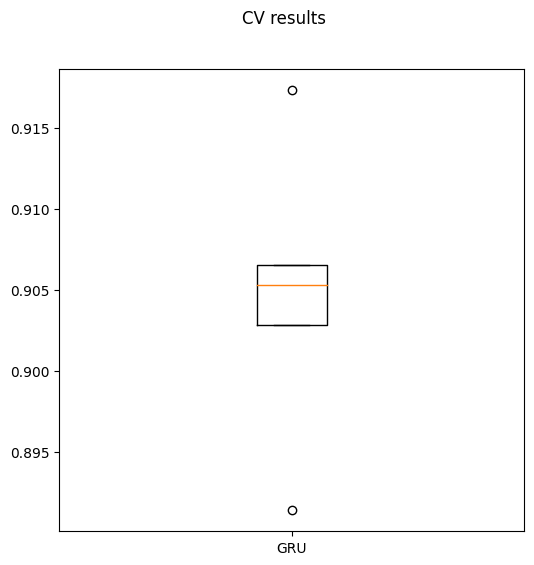

In [16]:
# Evaluate cross-validation results
fig = plt.figure()
fig.suptitle('CV results')
ax = fig.add_subplot(111)
plt.boxplot(search_results["cv_results"], labels=["GRU"])
fig.set_size_inches((6, 6))
plt.show()

Fortunately, the dispersion is very small and we are happy with the results. Let's train the best model using all the data.

In [17]:
# Take model best parameters
best_parameters = search_results["best_parameters"].item()
model = build_model(rnn_hidden_dim=best_parameters["rnn_hidden_dim"], word_embedding_dim=best_parameters["word_embedding_dim"])
model.fit(
    x_train_pad, 
    y_train_encoded, 
    batch_size=best_parameters["batch_size"], 
    epochs=best_parameters["epochs"], 
    callbacks=best_parameters["callbacks"]
)

Epoch 1/15
1875/1875 [==============================] - 26s 13ms/step - loss: 0.6568 - mean_squared_error: 0.0854 - accuracy: 0.7351
Epoch 2/15
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2845 - mean_squared_error: 0.0352 - accuracy: 0.9089
Epoch 3/15
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2555 - mean_squared_error: 0.0319 - accuracy: 0.9177
Epoch 4/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2394 - mean_squared_error: 0.0301 - accuracy: 0.9224
Epoch 5/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2288 - mean_squared_error: 0.0288 - accuracy: 0.9253
Epoch 6/15
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2210 - mean_squared_error: 0.0279 - accuracy: 0.9280
Epoch 7/15
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2145 - mean_squared_error: 0.0271 - accuracy: 0.9296


#### Evaluation of the testing dataset

We load the testing dataset and make the same treatment as for the training set to clean and tokenize the text sequences. Then, we use our fitted model to predict the categories. As the resulting vector is giving the probabilities of being from one class or another, we need to round the result by taking the class with higher probability.

In [18]:
# Now, use open the test datast file
test_data = pd.read_csv("../data/test.txt", sep=",", quotechar='"', header=None, names=["category", "headline", "text"])
test_data["headline_text"] = test_data["headline"]+ " " + test_data["text"]
x_test_encoded = encode_dataset(test_data["headline_text"], vectorizer.vocabulary_)
x_test_pad = pad_sequences(x_test_encoded, maxlen=max_length)
test_data["category"] = test_data["category"] - 1

In [19]:
y_pred = model.predict(x_test_pad)
y_pred_rounded = np.argmax(y_pred, axis=1)
y_pred_rounded

238/238 [==============================] - 1s 4ms/step


array([2, 3, 3, ..., 1, 2, 2])

Finally, let's calculate the confusion matrix and the classification report to show all main metrics. We plot the confusion matrix to have a better image of our results.

In [20]:
y_test = test_data["category"].tolist()
conf_matrix = confusion_matrix(y_test, y_pred_rounded)
print(classification_report(y_test, y_pred_rounded))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1900
           1       0.94      0.98      0.96      1900
           2       0.90      0.87      0.89      1900
           3       0.90      0.89      0.90      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



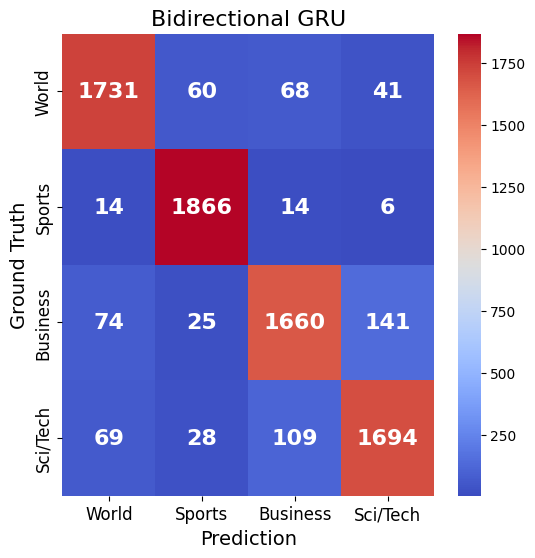

In [21]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize = (6, 6))
ax = sns.heatmap(conf_matrix, cmap="coolwarm", annot=True, fmt='d', annot_kws={"size": 16, "weight": "bold"})
labels = ['World', 'Sports', 'Business', 'Sci/Tech']
ax.set_xticklabels(labels, fontsize = 12)
ax.set_yticklabels(labels, fontsize = 12)
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_ylabel('Ground Truth', fontsize = 14)
ax.set_title('Bidirectional GRU', fontsize = 16)
plt.show()

#### Conclusions

We built a Bidirectional GRU model to classify news in 4 different classes. The accuracy and the F1-score is ~91% which is quite good, but it can probably be improved doing some hyperparameter tuning. The F1-score is slightly lower for Business and Sci/Tech classes, where the model seems to confuse one with the other in some occasions. Probably the type of vocabulary used in both topics is similar or the content of the news. Sports class is clearly the best predicted with a F1-score of 96%.